# Homework 2: CV.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import models

**<font color=blue>Observations:</font>**

For the sake of curiosity, we'll first train a simple convolutional network on our dataset, just to see how it performs in this classification task

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda', index=0)

**<font color=blue>Observations:</font>**

- We'll load the data directly from the original folder structure with `ImageFolder`.
- Aside from training a simple network, we'll train a ResNet, for comparison. To this end, we won't include any data augmentation technique (in our `transforms.Compose` object) at the beginning, other than image normalization. Mechanisms for improving the score will be discussed at the end.

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


trainset = torchvision.datasets.ImageFolder(root="/kaggle/input/100-bird-species/train/", transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=0, shuffle=True)

testset = torchvision.datasets.ImageFolder(root="/kaggle/input/100-bird-species/test/", transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, num_workers=0, shuffle=False)

dataloaders = {
    "train": trainloader,
    "test": testloader
}
datasizes = {
    "train": len(trainset),
    "test": len(testset)
}
CLASSES = list(trainset.class_to_idx.keys())

Let's check if we correctly loaded the train and test sets:

In [5]:
datasizes, len(CLASSES)

({'train': 58388, 'test': 2000}, 400)

Let's check a batch of sample images:

In [6]:
def imshow(img, size=(10, 10)):
    img = img / 2 + 0.5
    npimg = img.numpy()
    if size:
        plt.figure(figsize=size)
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Mini-bath sample")
    plt.axis("off")
    plt.pause(0.001)

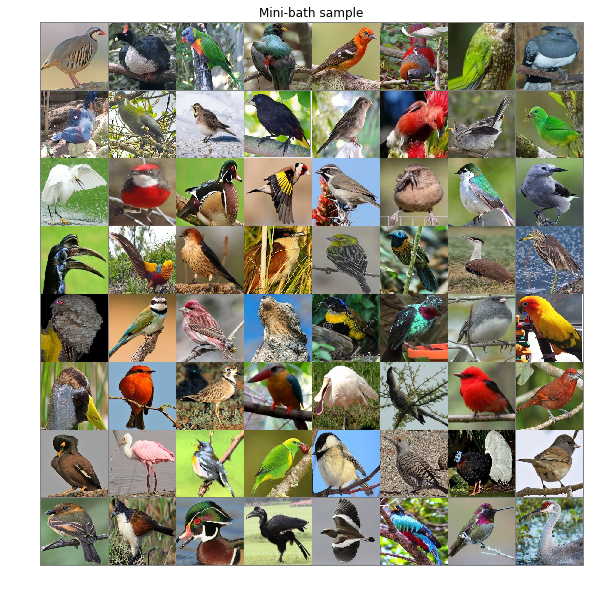

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

## Approach 1: Simple CNN

Just define an arbitrary one:

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16*53*53, out_features=2809)
        self.fc2 = nn.Linear(in_features=2809, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=len(CLASSES))
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*53*53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Let's train this network:

In [9]:
simple_model = SimpleCNN()
simple_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(simple_model.parameters(), lr=0.01, momentum=0.9)

In [10]:
for epoch in range(2):
    running_loss = 0.0
    best_acc = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = simple_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        corrects = torch.sum(preds == labels.data)
        # print Running loss
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}. Loss after {i + 1} batches: {running_loss / 100}')
            running_loss = 0.0
    print(f'Accuracy after Epoch {epoch + 1} Accuracy: {corrects.double()/datasizes["train"]}')

Epoch 1. Loss after 100 batches: 5.990018873214722
Epoch 1. Loss after 200 batches: 5.980966243743897
Epoch 1. Loss after 300 batches: 5.871526374816894
Epoch 1. Loss after 400 batches: 5.69178168296814
Epoch 1. Loss after 500 batches: 5.514547028541565
Epoch 1. Loss after 600 batches: 5.26740330696106
Epoch 1. Loss after 700 batches: 4.9638149499893185
Epoch 1. Loss after 800 batches: 4.783278093338013
Epoch 1. Loss after 900 batches: 4.62247052192688
Accuracy after Epoch 1 Accuracy: 3.4253613756251286e-05
Epoch 2. Loss after 100 batches: 4.320641396045684
Epoch 2. Loss after 200 batches: 4.236826260089874
Epoch 2. Loss after 300 batches: 4.112352418899536
Epoch 2. Loss after 400 batches: 3.9898469257354736
Epoch 2. Loss after 500 batches: 3.851925420761108
Epoch 2. Loss after 600 batches: 3.7502106618881226
Epoch 2. Loss after 700 batches: 3.605979630947113
Epoch 2. Loss after 800 batches: 3.5603501272201536
Epoch 2. Loss after 900 batches: 3.492193629741669
Accuracy after Epoch 2 Ac

**<font color=blue>Observations:</font>**
- As expected, this simple network can handle the classification of $400$ classes. Moreover, just with $2$ epochs the training was not that fast.
- For this reason we'll try fine-tuning a more complex model. As we've just concluded, a more complex model is necessary for dealing with a large number of classes, and fine-tuning is recommended in order to:
    - use the model's knowledge (weights) after training on another similar dataset, and
    - reduce the training time that has to be spent, when training from the very beginning.

## Approach 2: ResNet

- ResNet is a residual neural network proposed to deal with the vanishing/exploding grandient problem. To this end, its architecture consists of Shortcut or Skipping connections, where the input $x$ to the $i$-th layers is additively passed as an identity to to the output of that layer. That is if, $x$ and $y$ are the input and outputs of the $i$-th layer, and $\mathcal{F}$ the mapping performed by that layer, then $y$ equals:

$$y = \mathcal{F}(x, W_i) + x$$

If $x$ and $F$ have no the same dimensions, then a projection $W_s$ is necessary:

$$y = \mathcal{F}(x, W_i) + W_sx$$

Even though we viewed $\mathcal{F}(x, W_i)$ as a single layer, the authors gave it a more abstract meaning: it can consist of multiple layers, it can be a FCL or CNN, etc. Since the experiments were carried out on ImageNet, the architecture used is similar to the residual network below:

![](https://i.ibb.co/JdD28PX/Screenshot-from-2022-05-08-22-25-23.png)


**<font color=blue>Notes:</font>**

For our training we'll use a pretrained ResNet model of $18$ layers. Fo fine-tuning we'll:

- Freeze the parameters of ResNet.
- Append to it a linear layer with `out_features=400` (the dataset classes).

In [14]:
model_resnet = models.resnet18(pretrained=True)

for param in model_resnet.parameters():
    param.requires_grad = False
    
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, len(CLASSES))
model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_resnet.parameters(), lr=0.003, momentum=0.9)
step_lr = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
def train_model(model, criterion, optimizer, scheduler, epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch, epochs-1))
        print("-"*10)
        
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0 
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parametsrs
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == "train":
                scheduler.step()
            
            epoch_loss = running_loss / datasizes[phase]
            epoch_acc = running_corrects.double()/datasizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            if(phase == "test" and epoch_acc > best_acc):
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print("Training complete in {:0f}m {:0f}s".format(time_elapsed//60, time_elapsed%60))
    print("Best val Acc: {}:4f".format(best_acc))
    
    # load best model parameters
    model.load_state_dict(best_model_wts)
    return model

In [17]:
model_resnet = train_model(model_resnet, criterion, optimizer_ft, step_lr, epochs=5)

Epoch 0/4
----------
train Loss: 4.1806 Acc: 0.3447
test Loss: 2.5233 Acc: 0.6840

Epoch 1/4
----------
train Loss: 2.1302 Acc: 0.7244
test Loss: 1.3698 Acc: 0.8480

Epoch 2/4
----------
train Loss: 1.4249 Acc: 0.8025
test Loss: 0.9423 Acc: 0.8840

Epoch 3/4
----------
train Loss: 1.1126 Acc: 0.8339
test Loss: 0.7446 Acc: 0.9110

Epoch 4/4
----------
train Loss: 0.9365 Acc: 0.8519
test Loss: 0.6210 Acc: 0.9180

Training complete in 17.000000m 5.605313s
Best val Acc: 0.918:4f


**<font color=blue>Observations</font>**
- Without any data augmentation, just a simple fine-tuning of Resnet (with only $5$ epochs) gives approx. $91.8\%$ accuracy.
- Training time, although not measured, is faster than training a NN from zero. This is due to the fact that we only do backpropagation for the last appended linear layers.

Let's check some sample predictions on the test set:

In [21]:
def imshowaxis(ax, img, orig, pred):
    img = img / 2 + 0.5
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    if orig != pred:
        ax.set_title("Gold: " + orig + "\n" + "Pred: " + pred, color="red")
    else:
        ax.set_title("Gold: " + orig + "\n" + "Pred: " + pred)
    ax.axis("off")


def visualize_model(model, num_images=25):
    was_training = model.training
    model.eval()
    images_so_far = 0
    figure, ax = plt.subplots(5, 5, figsize=(20, 20))
    
    
    with torch.no_grad():
        for i , (inputs, labels) in enumerate(dataloaders["test"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for i in range(5):
                for j in range(5):
                    if images_so_far < num_images:
                        imshowaxis(ax[i][j], inputs.cpu().data[images_so_far], CLASSES[labels[images_so_far]], CLASSES[preds[images_so_far]])
                    else:
                        model.train(mode=was_training)
                        return
                    images_so_far += 1
        model.train(mode=was_training)


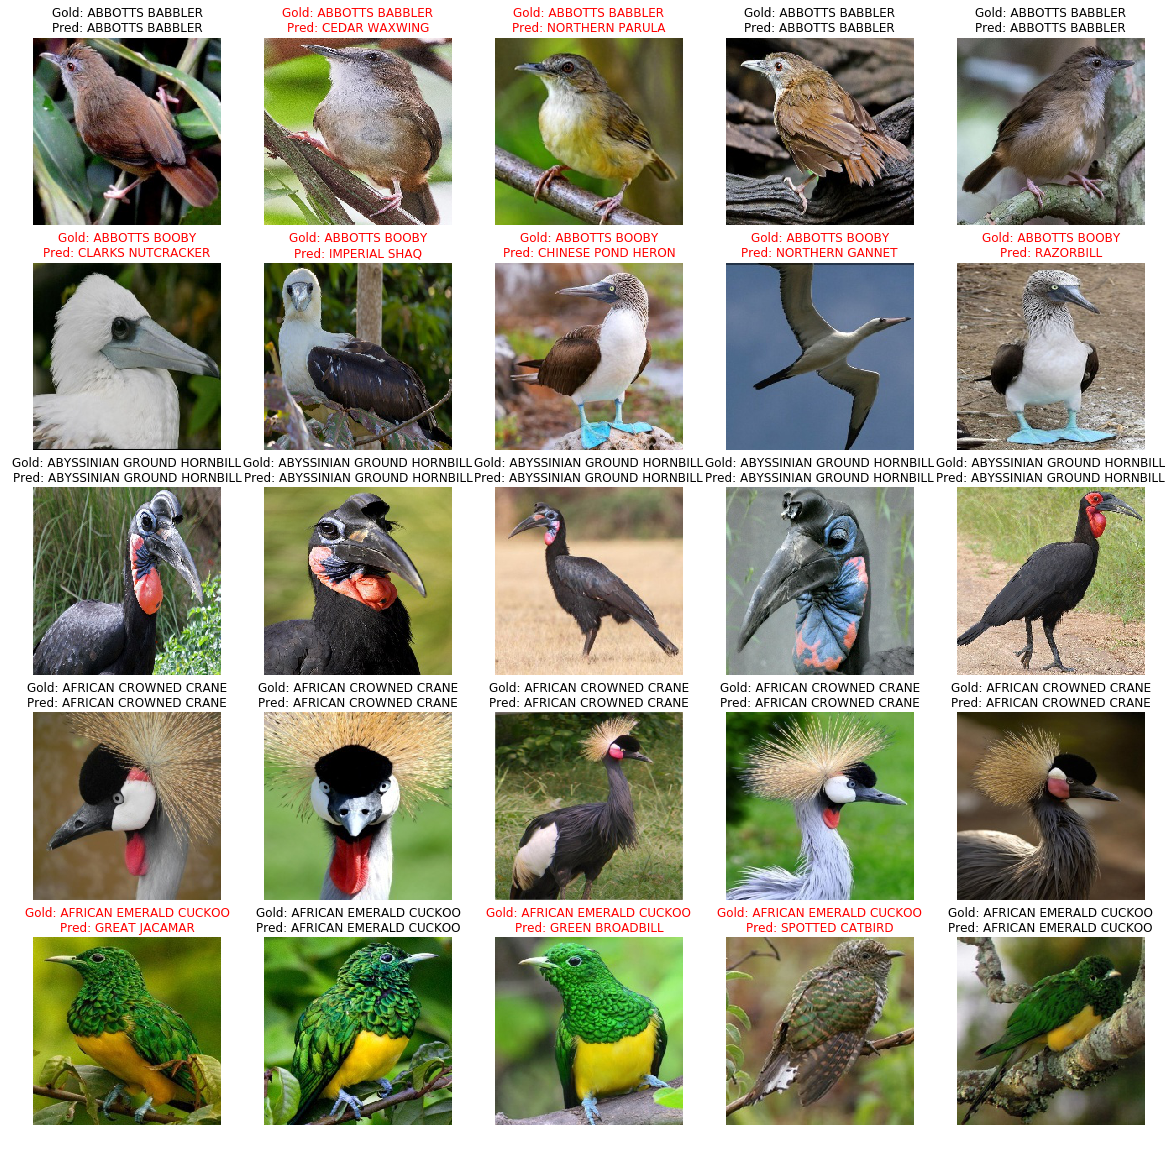

In [22]:
visualize_model(model_resnet)

### Approach 3: ResNet + some data augmentation

In order to improve predictions we can a) do some data augmentation and/or b) try different set of hyperparameter values. An exhaustive data augmentation/hyperparameter tuning is time-consuming, so we let's experiment with the following:

Data augmentation:
- Perform some random rotation of $(-8, +8)$ degrees.
- Blur and image with Gaussian blur.
- Change the image's contrast.

Hyperparameter tuning:
- Change the scheduler from Step to Exponential.
- Increase the learning rate from $0.003$ to $0.03$.

In [23]:
import cv2

In [24]:
class GaussianBlur(object):
    def __init__(self, kernel_size, std_dev):
        self.kernel_size = kernel_size
        self.std_dev = std_dev

    def __call__(self, img):
        image = np.array(img)
        image_blur = cv2.GaussianBlur(image, self.kernel_size, self.std_dev)
        return Image.fromarray(image_blur)

In [25]:
transform_aug = transforms.Compose(
    [transforms.RandomRotation([-8,+8]),
     GaussianBlur((65, 65), 10),
     transforms.ColorJitter(brightness=0, contrast=0.4, saturation=0, hue=0),
     transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


trainset_aug = torchvision.datasets.ImageFolder(root="/kaggle/input/100-bird-species/train/", transform=transform_aug)
trainloader_aug = torch.utils.data.DataLoader(trainset_aug, batch_size=64, num_workers=0, shuffle=True)

testset_aug = torchvision.datasets.ImageFolder(root="/kaggle/input/100-bird-species/test/", transform=transform_aug)
testloader_aug = torch.utils.data.DataLoader(testset_aug, batch_size=64, num_workers=0, shuffle=False)

dataloaders_aug = {
    "train": trainloader_aug,
    "test": testloader_aug
}
datasizes_aug = {
    "train": len(trainset_aug),
    "test": len(testset_aug)
}
CLASSES = list(trainset_aug.class_to_idx.keys())

In [28]:
model_resnet_aug = models.resnet18(pretrained=True)

for param in model_resnet_aug.parameters():
    param.requires_grad = False
    
num_ftrs = model_resnet_aug.fc.in_features
model_resnet_aug.fc = nn.Linear(num_ftrs, len(CLASSES))
model_resnet_aug = model_resnet_aug.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft_aug = optim.SGD(model_resnet_aug.parameters(), lr=0.03, momentum=0.9)
exp_lr = lr_scheduler.ExponentialLR(optimizer_ft_aug, gamma=0.1)

In [29]:
model_ft_aug = train_model(model_resnet_aug, criterion, optimizer_ft_aug, exp_lr, epochs=5)

Epoch 0/4
----------
train Loss: 1.7010 Acc: 0.6541
test Loss: 0.4620 Acc: 0.8955

Epoch 1/4
----------
train Loss: 0.5287 Acc: 0.8949
test Loss: 0.3375 Acc: 0.9340

Epoch 2/4
----------
train Loss: 0.4938 Acc: 0.9042
test Loss: 0.3272 Acc: 0.9380

Epoch 3/4
----------
train Loss: 0.4857 Acc: 0.9068
test Loss: 0.3239 Acc: 0.9395

Epoch 4/4
----------
train Loss: 0.4851 Acc: 0.9074
test Loss: 0.3235 Acc: 0.9365

Training complete in 15.000000m 37.918486s
Best val Acc: 0.9395:4f


**<font color=blue>Observations and conclusions:</font>**
- We indeed observe an improvement on the prediction accuracy: approx $94.0\%$ over $91.8\%$ with the previous ResNet model.
- This maybe due to all the changes we described above, or purely due to increasing the learning rate (increasing learnig rate speeds up training convergence). Maybe if we didn't do anything and just increased the number of epochs, we could have achieved the same result. It's difficult to tell.
- In any case, we can see than it's worth:
    - Fine-tuning a pretrained model and not trying to reinvent the wheel by training a model from scratch, specially if we don't have enough data and computational resources.
    - Including some form of data augmentation or hyperparameter tuning in order to improve the model's predictions.

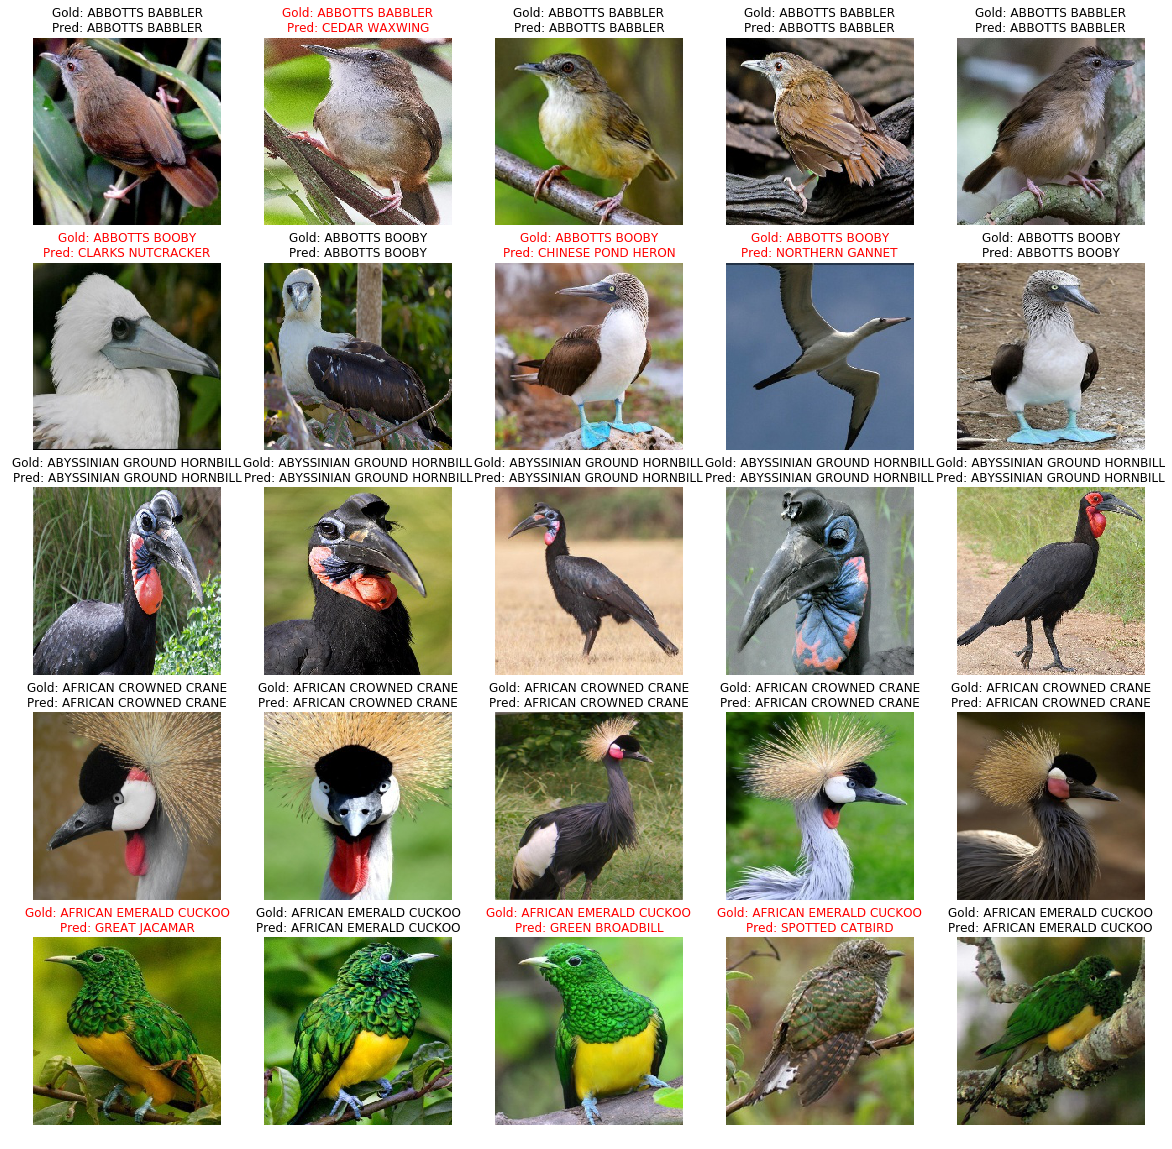

In [30]:
visualize_model(model_ft_aug)